## Проект по курсу "Теория вероятностей и математическая статистика"


### Тема:
Исследовать связь между длительностью фильма Runtime (Minutes) и заработанными деньгами (Revenue (Millions)), найти какая длина фильма самая выгодная.<br>
Источник: https://www.kaggle.com/PromptCloudHQ/imdb-data 

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib.pyplot import figure
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

In [86]:
# загрузим данные, посмотрим что дано
df = pd.read_csv('IMDB-Movie-Data.csv')
df.head(3)

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


In [87]:
df.shape

(1000, 12)

In [88]:
# посмотрим на характеристики время фильма
df['Runtime (Minutes)'].describe()

count    1000.000000
mean      113.172000
std        18.810908
min        66.000000
25%       100.000000
50%       111.000000
75%       123.000000
max       191.000000
Name: Runtime (Minutes), dtype: float64

In [89]:
# посмотрим на характеристику кассовых сборов с фильма
df['Revenue (Millions)'].describe()

count    872.000000
mean      82.956376
std      103.253540
min        0.000000
25%       13.270000
50%       47.985000
75%      113.715000
max      936.630000
Name: Revenue (Millions), dtype: float64

Видно, что количество наблюдений в столбцах разное, не хватает данных в кассовых сборах. Предположим, что не хватает данных о тех фильмах, которые по тем или иным причиным в прокат не вышли или прибыль была настолько маленькой, что и не стоит упоминания.
Тогда пропущенные значения в кассовых сборах заменим на "0".

In [90]:
df['Revenue (Millions)'] = df['Revenue (Millions)'].fillna(0)

In [91]:
# Посчитаем коэффициент корреляции Пирсона
np.corrcoef(df['Runtime (Minutes)'], df['Revenue (Millions)'])

array([[1.        , 0.30000431],
       [0.30000431, 1.        ]])

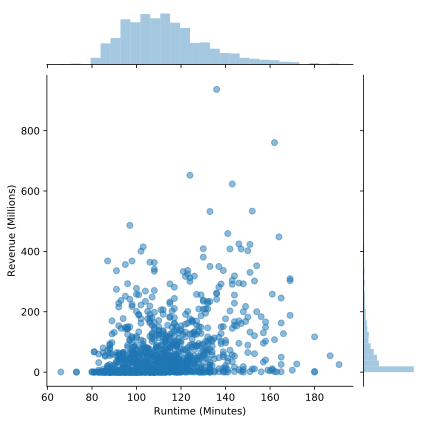

In [108]:
# Коэффициент меньше 0.5, как будто бы не слишком сильна связь между длиной фильма и его кассовыми сборами.
# Посмотрим визуально. 
import seaborn as sns
sns.jointplot(df['Runtime (Minutes)'], df['Revenue (Millions)'], kind='scatter', joint_kws={'alpha':0.5})

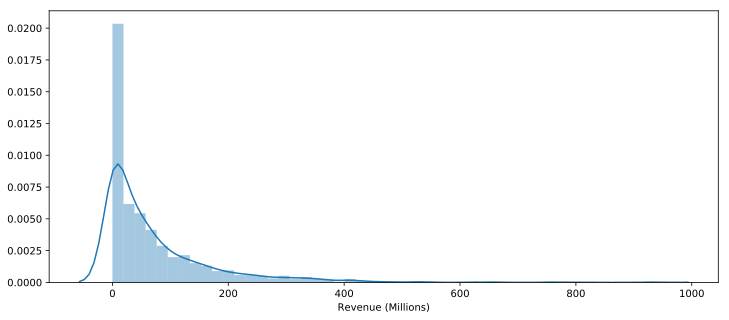

In [109]:
# посмотрим на распределение кассовых сборов
sns.distplot(df['Revenue (Millions)'])

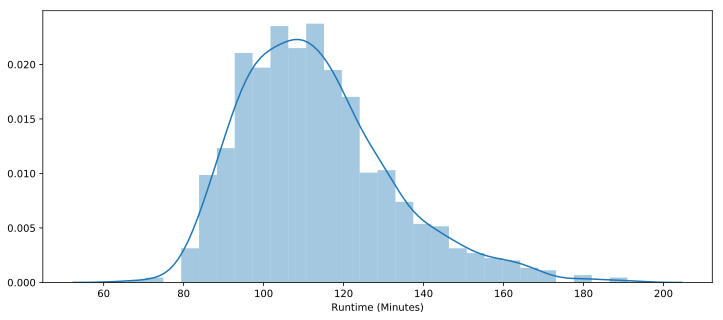

In [94]:
# посмотрим на распределение длительности фильмов
sns.distplot(df['Runtime (Minutes)'])

Для начала будем считать, что распределение длительности фильмов в датасете -- нормальное, оно очень отдаленно напоминает нормальное, но иначе я не знаю как с ним обращаться.
Генеральной совокупностью будет тогда все количество фильмов, представленное в датасете.
Возьмем за гипотезу, что нет связи между кассовыми сборами и длительностью фильма, тогда если мы посмотрим на выборку из 25% самых дорогих фильмов, средняя длина фильма не должна статистически значимо отличаться от средней длины фильмов в целом. 

In [95]:
# Выберем 25% самых доходных фильмов:
q3 = df['Revenue (Millions)'].quantile(0.75)
df_rev_q3 = df.loc[(df['Revenue (Millions)'] >= q3)]
M_time_gp = df['Runtime (Minutes)'].mean()
M_time_sample_q3 = df_rev_q3['Runtime (Minutes)'].mean()
print(f'Средняя длительность фильмов: {M_time_gp}\nСредняя длительность фильмов с высокими кассовыми сборами: {M_time_sample_q3}')

Средняя длительность фильмов: 113.172
Средняя длительность фильмов с высокими кассовыми сборами: 121.948


In [96]:
# Найдем разброс по времени в полном датафрейме
D = df['Runtime (Minutes)'].var()
D

353.8502662662666

In [97]:
# Посмотрим сколько значений попало в четверть самых прибыльных фильмов:
df_rev_q3['Runtime (Minutes)'].shape, df['Runtime (Minutes)'].shape

((250,), (1000,))

In [98]:
# Найдем доверительный интервал для матожидания в выборке с надежностью 0.95:
import math
sigma = math.sqrt(D/df_rev_q3['Runtime (Minutes)'].shape[0])
sigma

1.1897062936141283

In [99]:
# левая граница доверительного интервала:
A = M_time_sample_q3 - 2 * sigma
# правая граница доверительного интервала:
B = M_time_sample_q3 + 2 * sigma
# Интервал: 
(A, B)

(119.56858741277173, 124.32741258722825)

Однако оказывается, что M_time_gp, равное 113.172, не попадает в доверительный интервал M_time_sample_q3, значит, что зависимость между длительностью фильма и кассовыми сборами есть.

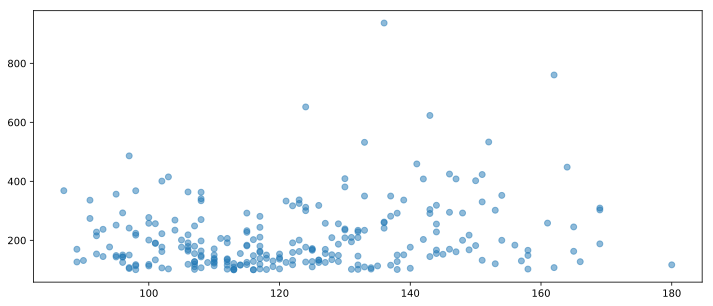

In [100]:
# Посмотрим еще раз на самые прибыльные фильмы:
plt.scatter(df_rev_q3['Runtime (Minutes)'], df_rev_q3['Revenue (Millions)'], alpha=0.5)
plt.show()

Text(0, 0.5, 'Revenue (Millions)')

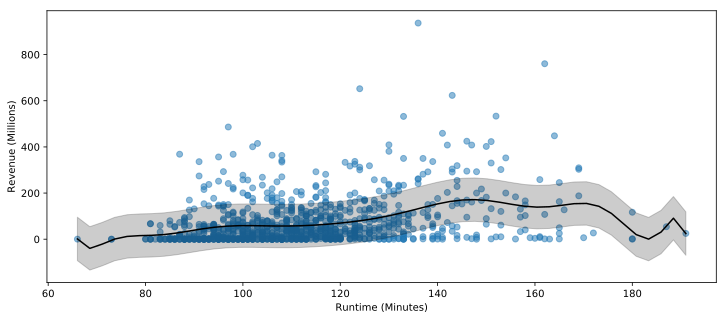

In [101]:
# Вторая задача в работе была определить какая длина фильма самая выгодная.
# линейного тренда не видно, сделаем нелинейный тренд:
plt.scatter(df['Runtime (Minutes)'], df['Revenue (Millions)'], alpha=0.5)
x = df['Runtime (Minutes)']
y = df['Revenue (Millions)']
params = np.polyfit(x, y, 15)
xp = np.linspace(x.min(), x.max())
yp = np.polyval(params, xp)
plt.plot(xp, yp, 'k')

sig = np.std(y - np.polyval(params, x))
plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)

plt.xlabel("Runtime (Minutes)")
plt.ylabel("Revenue (Millions)")

Text(0, 0.5, 'Revenue (Millions)')

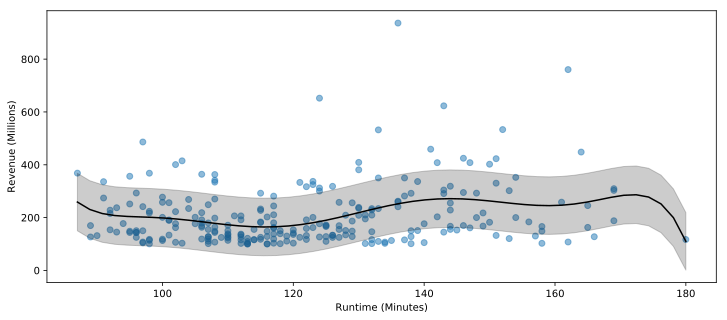

In [102]:
# И тоже самое для самых прибыльних фильмов:
plt.scatter(df_rev_q3['Runtime (Minutes)'], df_rev_q3['Revenue (Millions)'], alpha=0.5)
x = df_rev_q3['Runtime (Minutes)']
y = df_rev_q3['Revenue (Millions)']
params = np.polyfit(x, y, 7)
xp = np.linspace(x.min(), x.max())
yp = np.polyval(params, xp)
plt.plot(xp, yp, 'k')

sig = np.std(y - np.polyval(params, x))
plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)

plt.xlabel("Runtime (Minutes)")
plt.ylabel("Revenue (Millions)")

Из тренда видно, что максимум прибыли приходится примерно на 145 минут.